In [1]:
from run_decoder import load_model

import pandas as pd
import numpy as np
import torch

/home/cbelem/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# [Control Experiment 2]

In this notebook, we take the multinomial samples generated in the first control experiment and we select half of their generations for a second control experiment, focused on estimating the properties of generated sequences in a more diverse region of the decoding spectrum. 

Particularly, if we're interested in making claims regarding the properties of decoding algorithms, we should make sure they cover a wider broader of the generation spectrum. Multinomial sampling provides this. Since it's sampling randomly from the model distribution it has enough randomness to cover a wide variety of sequences (instead of converging to the same exact sequence). 


**In this notebook**, you'll find the code that loads the generated sentences with **multinomial** (or ancestral sampling) in the first control experiment. Then, we will tokenizer them using the corresponding model, selecting up to the first 50 tokens.

In [10]:
MODEL_NAME = "EleutherAI/pythia-70m"
MODEL_NAME = "EleutherAI/pythia-1.4b"
MODEL_NAME = "EleutherAI/pythia-2.8b"

if MODEL_NAME.endswith("2.8b"):
    BASE_DIR = f"/extra/ucinlp1/cbelem/experiment-ro-prompts/generations/uncond"
    OUTPUT_DIR = f"/extra/ucinlp1/cbelem/experiment-ro-prompts/generations-results/uncond-half-multinomial/{MODEL_FILENAME}"
    DATASET_PATH = f"{BASE_DIR}/{MODEL_FILENAME}-multinomial.csv"

else:
    BASE_DIR = f"/extra/ucinlp1/cbelem/experiment-ro-prompts/generations-results/uncond"
    OUTPUT_DIR = f"{BASE_DIR}-half-multinomial/{MODEL_FILENAME}"
    DATASET_PATH = f"{BASE_DIR}/{MODEL_FILENAME}/multinomial.csv"

mult_data = pd.read_csv(DATASET_PATH, index_col=0)
print(len(mult_data), mult_data.columns)
mult_data.head()

131072 Index(['sampling_kwargs', 'sequence_log_prob', 'sequence',
       'seq_trans_log_probs', 'seq_entropy_log_probs'],
      dtype='object')


,sampling_kwargs,sequence_log_prob,sequence,seq_trans_log_probs,seq_entropy_log_probs
0,"{'do_sample': True, 'num_beams': 1}",-159.001526,# -*- coding: utf-8 -*-\n\n# Copyright (c) 200...,[-4.25621414e+00 -3.50089359e+00 -1.71435475e-...,[6.24843740e+00 4.77410412e+00 8.90498519e-01 ...
1,"{'do_sample': True, 'num_beams': 1}",-31.050560,"#include ""caffe/layer.h""\n#include ""caffe/laye...",[-4.25621414e+00 -1.97094822e+00 -7.76075125e-...,[6.24843740e+00 4.77410412e+00 1.04744852e+00 ...
2,"{'do_sample': True, 'num_beams': 1}",-187.262802,Q:\n\nWhat can I do if I find myself lost?\n\n...,[-2.0242403e+00 -2.8133120e-03 -5.6250958e-04 ...,[6.24843740e+00 3.44278552e-02 6.99321413e-03 ...
3,"{'do_sample': True, 'num_beams': 1}",-197.876038,Q:\n\nAre there any good sources of material o...,[-2.0242403e+00 -2.8133120e-03 -5.6250958e-04 ...,[6.2484374e+00 3.4427855e-02 6.9932141e-03 6.4...
4,"{'do_sample': True, 'num_beams': 1}",-16.165073,<?php\n\n/*\n * This file is part of the Symfo...,[-5.10383320e+00 -7.00230420e-01 -9.23322588e-...,[6.24843740e+00 7.29738057e-01 5.58597088e-01 ...


In [11]:
MODEL_FILENAME, MODEL, TOKENIZER, DEVICE = load_model(MODEL_NAME, device="cuda:5")
print(MODEL_FILENAME)

EleutherAI__pythia-2.8b


# Tokenize and half the sequences

In this section, we tokenizer all the sequences in the `mult_data` dataframe (assumed to be located in a column named `sequence`). We iterate in batches of 64 sequences and split the sequences using `SPLIT_AFTER_TOKENS`.

In [12]:
sequences = mult_data["sequence"].values
n_seqs = len(sequences)
BATCH_SIZE = 64
SPLIT_AFTER_TOKENS = 50


half_sequences = []
lengths, half_lengths = [], []

for start in range(0, n_seqs, BATCH_SIZE):
    end = min(start+BATCH_SIZE, n_seqs)
    batch = sequences[start:end].tolist()
    
    sequences_enc = TOKENIZER.batch_encode_plus(batch, add_special_tokens=False).input_ids
    sequences_enc_half = [seq[:SPLIT_AFTER_TOKENS] for seq in sequences_enc]
    half_lengths.extend([len(s) for s in sequences_enc_half])

    sequences_enc_half = TOKENIZER.batch_decode(sequences_enc_half)
    half_sequences.extend(sequences_enc_half)
    lengths.extend([len(s) for s in sequences_enc])

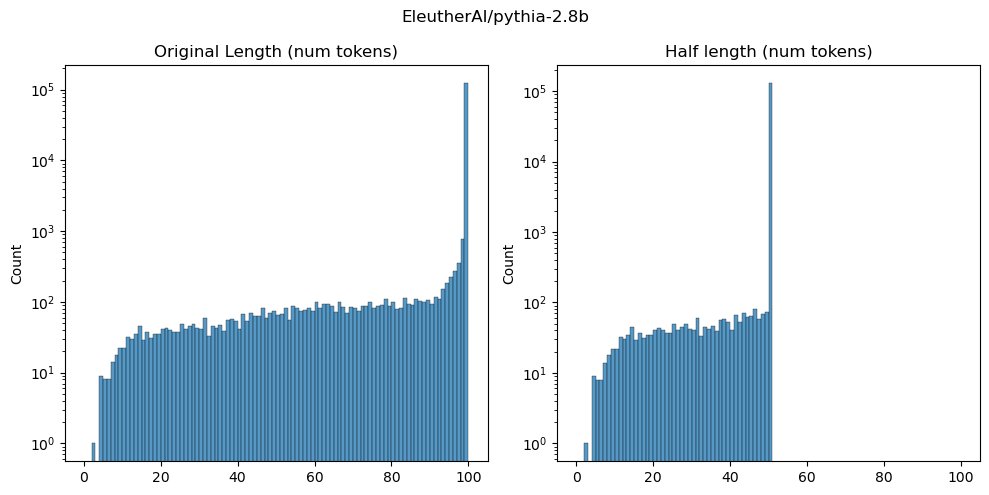

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(MODEL_NAME)

sns.histplot(lengths, binwidth=1, ax=axes[0], binrange=(0, 100))
axes[0].set_title("Original Length (num tokens)")
axes[0].set_yscale("log")

sns.histplot(half_lengths, binwidth=1, ax=axes[1], binrange=(0, 100))
axes[1].set_title("Half length (num tokens)")

axes[1].set_yscale("log")
plt.tight_layout()

In [16]:
half_sequences[:4]

['# -*- coding: utf-8 -*-\n\n# Copyright (c) 2004-2010 RHOQ, LLC and Contributors.\n# Maintainer:\n#\tEmail: M.Nugent at rhounet dot org\n',
 '#include "caffe/layer.h"\n#include "caffe/layers/loss_layer.h"\n#include "caffe/util/math_functions.h"\n#include "caffe/util/upgrade',
 "Q:\n\nWhat can I do if I find myself lost?\n\nOkay, so I was at my friend's place, and he told me about the location where he was going to make a portal, but when I went there, I",
 "Q:\n\nAre there any good sources of material on the development of quantum theory?\n\nI was thinking about the development of quantum mechanics. But there isn't a very good reference on the topic. Are there any good sources, or would"]

## Create the file and dump it

Note that there will be sequences where there is no continuation... This is because there were too little to tokens following it.

In [17]:
continuations = [seq.replace(pref, "") for seq, pref in zip(sequences, half_sequences)]

experiment_half = {
    "sequence": mult_data["sequence"].values,
    "prefix": half_sequences,
    "continuation": continuations,
    "sequence_num_tokens": lengths,
    "prefix_num_tokens": half_lengths,
    "continuation_num_tokens": [sl - pl for sl, pl in zip(lengths, half_lengths)],
    "sampling_kwargs":  mult_data["sampling_kwargs"].values,
    "original_filepath": [DATASET_PATH] * len(half_sequences)
}

experiment_half = pd.DataFrame(experiment_half)
experiment_half["prefix_kwargs"] = [{
    "tokenizer": TOKENIZER.__class__.__name__, 
    "split_after": SPLIT_AFTER_TOKENS,
}] * len(experiment_half)

experiment_half.head()

,sequence,prefix,continuation,sequence_num_tokens,prefix_num_tokens,continuation_num_tokens,sampling_kwargs,original_filepath,prefix_kwargs
0,# -*- coding: utf-8 -*-\n\n# Copyright (c) 200...,# -*- coding: utf-8 -*-\n\n# Copyright (c) 200...,# TODO:\n#\t- Add an option to allow this to b...,100,50,50,"{'do_sample': True, 'num_beams': 1}",/extra/ucinlp1/cbelem/experiment-ro-prompts/ge...,"{'tokenizer': 'GPTNeoXTokenizerFast', 'split_a..."
1,"#include ""caffe/layer.h""\n#include ""caffe/laye...","#include ""caffe/layer.h""\n#include ""caffe/laye...","_proto.h""\n\nnamespace caffe {\n\ntemplate <ty...",100,50,50,"{'do_sample': True, 'num_beams': 1}",/extra/ucinlp1/cbelem/experiment-ro-prompts/ge...,"{'tokenizer': 'GPTNeoXTokenizerFast', 'split_a..."
2,Q:\n\nWhat can I do if I find myself lost?\n\n...,Q:\n\nWhat can I do if I find myself lost?\n\n...,found that the portal was locked. So what did...,100,50,50,"{'do_sample': True, 'num_beams': 1}",/extra/ucinlp1/cbelem/experiment-ro-prompts/ge...,"{'tokenizer': 'GPTNeoXTokenizerFast', 'split_a..."
3,Q:\n\nAre there any good sources of material o...,Q:\n\nAre there any good sources of material o...,you recommend your favourite book/article on ...,100,50,50,"{'do_sample': True, 'num_beams': 1}",/extra/ucinlp1/cbelem/experiment-ro-prompts/ge...,"{'tokenizer': 'GPTNeoXTokenizerFast', 'split_a..."
4,<?php\n\n/*\n * This file is part of the Symfo...,<?php\n\n/*\n * This file is part of the Symfo...,please view the LICENSE\n * file that was dis...,100,50,50,"{'do_sample': True, 'num_beams': 1}",/extra/ucinlp1/cbelem/experiment-ro-prompts/ge...,"{'tokenizer': 'GPTNeoXTokenizerFast', 'split_a..."


In [19]:
import os

os.makedirs(OUTPUT_DIR, exist_ok=True)
experiment_half.to_csv(f"{OUTPUT_DIR}/raw_data.csv")